<a href="https://colab.research.google.com/github/buthaina279/P4DS/blob/main/ex2_imb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#for google drive
DATA_FILEPATH = "/content/drive/MyDrive/final_project/"

In [ ]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties # for unicode fonts
import sys
import datetime as dt
#import mp_utils as mp

from collections import OrderedDict

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# used to impute mean for data and standardize for computational stability
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn import linear_model
from sklearn import ensemble

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

In [ ]:
import pandas as pd, numpy as np
X_train = pd.read_csv(DATA_FILEPATH + 'train_36.csv',index_col=0) 
validation = pd.read_csv(DATA_FILEPATH + 'validation_36.csv',index_col=0) 
test = pd.read_csv(DATA_FILEPATH + 'test_36.csv',index_col=0) 

In [ ]:
print(validation.shape)
print(test.shape)

(60770, 40)
(121094, 40)


In [ ]:
X_test = pd.concat([validation, test], ignore_index=True, sort=False)
X_test.head()


,subject_id,hadm_id,icustay_id,los_icu,cmo,cmo_last,dnr,first_careunit_CSRU,admission_type_EMERGENCY,gender_M,...,insurance_Government,max_hours,glucose_mean,temperature_mean,oxygen saturation_mean,systolic blood pressure_mean,cmo_first,heart rate_mean,respiratory rate_mean,mort_icu
0,54135,150600,228783,1.134317,0.0,0.0,1.0,0,1,1,...,0,27,168.0,36.333333,99.5,126.0,0.0,70.0,17.5,0
1,54135,150600,228783,1.134317,0.0,0.0,1.0,0,1,1,...,0,27,175.5,36.888889,98.0,123.5,0.0,65.0,24.0,0
2,54135,150600,228783,1.134317,0.0,0.0,1.0,0,1,1,...,0,27,175.5,36.888889,100.0,144.0,0.0,72.0,15.0,0
3,54135,150600,228783,1.134317,0.0,0.0,1.0,0,1,1,...,0,27,175.5,36.888889,96.0,126.0,0.0,65.0,20.0,0
4,54135,150600,228783,1.134317,0.0,0.0,1.0,0,1,1,...,0,27,175.5,36.055556,99.0,126.0,0.0,61.0,19.0,0


In [ ]:
X_test.shape

(181864, 40)

In [ ]:
X_train.drop(['subject_id', 'hadm_id'], axis=1, inplace=True)
X_train.shape

(424018, 38)

In [ ]:
X_test.drop(['subject_id', 'hadm_id'], axis=1, inplace=True)
X_test.shape

(181864, 38)

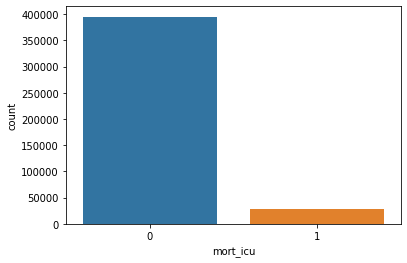

In [ ]:
import seaborn as sns
sns.countplot(X_train['mort_icu'])

In [ ]:
# X_train , X_test , y_train , y_test  = train_test_split(df , target , test_size = 0.3)
# print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(465596, 38) (199542, 38) (465596,) (199542,)


In [ ]:
y_train = X_train["mort_icu"]

In [ ]:
y_test = X_test["mort_icu"]

In [ ]:
#remove the label and icu from the test data 

X_test = X_test.drop(['mort_icu','icustay_id'],axis=1).values
y_test = y_test.values

In [ ]:
#df = pd.read_csv('X_design_matrix.csv').set_index('icustay_id')

# create X by dropping idxK and the outcome
y = y_train.values
idxK = X_train['icustay_id']
X = X_train.drop(['mort_icu','icustay_id'],axis=1).values

print('{} observations. Outcome rate: {:2.2f}%.'.format(X.shape[0],
                                                        100.0*np.mean(y)))

424018 observations. Outcome rate: 6.89%.


In [ ]:
#df = pd.read_csv('X_design_matrix.csv').set_index('icustay_id')

# create X by dropping idxK and the outcome
# y = df['mort_icu'].values = y_train
# idxK = df['icustay_id'] = train_ids
# X = df.drop(['mort_icu','icustay_id'],axis=1).values = train

# print('{} observations. Outcome rate: {:2.2f}%.'.format(X.shape[0],
#                                                         100.0*np.mean(y)))

Random time during the first 24 hours

In [ ]:
# parameters from grid search
xgb_mdl = xgb.XGBClassifier(colsample_bytree=0.7, silent=1,
                            learning_rate = 0.01, n_estimators=1000,
                            subsample=0.8, max_depth=9)

models = {'xgb': xgb_mdl,
          'lasso': linear_model.LassoCV(cv=5,fit_intercept=True,normalize=True,max_iter=10000),
          'logreg': linear_model.LogisticRegression(fit_intercept=True),
          'l2': linear_model.LogisticRegressionCV()
          #'rf': ensemble.RandomForestClassifier()
         }


# create k-fold indices
K = 5 # number of folds
idxK = np.random.permutation(X.shape[0])
idxK = np.mod(idxK,K)

mdl_val = dict()
results_val = dict()
pred_val = dict()
pred_val_merged = dict()
for mdl in models:
    print('=============== {} ==============='.format(mdl))
    mdl_val[mdl] = list()
    results_val[mdl] = list() # initialize list for scores
    pred_val[mdl] = dict()
    pred_val_merged[mdl] = np.zeros(X.shape[0])
    
    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])]) 

    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = sklearn.base.clone(estimator).fit(X[idxK != k, :], y[idxK != k])

        # get prediction on this dataset
        if mdl in ('lasso','ridge'):
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]
            
        pred_val_merged[mdl][idxK==k] = curr_prob
        pred_val[mdl][k] = curr_prob

        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        results_val[mdl].append(curr_score)

        # save the current model
        mdl_val[mdl].append(curr_mdl)
        
        print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))
    
tar_val = dict()
for k in range(K):
    tar_val[k] = y[idxK==k]

=============== xgb ===============
2022-07-18 19:35:07.782938 - Finished fold 1 of 5. AUROC 0.978.
2022-07-18 19:55:06.458543 - Finished fold 2 of 5. AUROC 0.978.
2022-07-18 20:13:49.213839 - Finished fold 3 of 5. AUROC 0.977.
2022-07-18 20:32:10.417901 - Finished fold 4 of 5. AUROC 0.979.
2022-07-18 20:50:43.635775 - Finished fold 5 of 5. AUROC 0.979.
=============== lasso ===============
2022-07-18 20:50:55.908181 - Finished fold 1 of 5. AUROC 0.870.
2022-07-18 20:51:08.114129 - Finished fold 2 of 5. AUROC 0.869.
2022-07-18 20:51:19.868531 - Finished fold 3 of 5. AUROC 0.874.
2022-07-18 20:51:30.938854 - Finished fold 4 of 5. AUROC 0.867.
2022-07-18 20:51:43.393062 - Finished fold 5 of 5. AUROC 0.874.
=============== logreg ===============
2022-07-18 20:51:51.824708 - Finished fold 1 of 5. AUROC 0.877.
2022-07-18 20:51:59.673097 - Finished fold 2 of 5. AUROC 0.877.
2022-07-18 20:52:06.675363 - Finished fold 3 of 5. AUROC 0.879.
2022-07-18 20:52:16.506709 - Finished fold 4 of 5. AURO

these are the results you should report as they did 

In [ ]:
# average AUROC + min/max
for mdl in models:
    curr_score = np.zeros(K)
    for k in range(K):
        curr_score[k] = metrics.roc_auc_score(tar_val[k], pred_val[mdl][k])
    print('{}\t{:0.3f} [{:0.3f}, {:0.3f}]'.format(mdl, np.mean(curr_score), np.min(curr_score), np.max(curr_score)))


xgb	0.978 [0.977, 0.979]
lasso	0.871 [0.867, 0.874]
logreg	0.877 [0.873, 0.879]
l2	0.877 [0.873, 0.879]


In [ ]:
# average AUPRC + min/max
for mdl in models:
   curr_score = np.zeros(K)
   for k in range(K):
       curr_score[k] = metrics.average_precision_score(tar_val[k], pred_val[mdl][k])
   print('{}\t{:0.3f} [{:0.3f}, {:0.3f}]'.format(mdl, np.mean(curr_score), np.min(curr_score), np.max(curr_score)))

xgb	0.867 [0.865, 0.869]
lasso	0.481 [0.471, 0.494]
logreg	0.491 [0.484, 0.503]
l2	0.491 [0.484, 0.503]


##XGB

validation the results

take the best model and fit it on the training set

In [ ]:
xgb_mdl

XGBClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
              n_estimators=1000, silent=1, subsample=0.8)

In [ ]:
xgb_mdl.fit(X, y)

XGBClassifier(colsample_bytree=0.7, learning_rate=0.01, max_depth=9,
              n_estimators=1000, silent=1, subsample=0.8)

In [ ]:
final_predictions=xgb_mdl.predict(X_test)

In [ ]:
#final_predictions = np.argmax(xgb_mdl.predict(X_test))

In [ ]:
# final_avg_auroc = metrics.average_precision_score(y_test, final_predictions)
# final_avg_auroc

In [ ]:
from sklearn.metrics import plot_confusion_matrix
cm = confusion_matrix(y_test, final_predictions)
print('confusion matrix:')
print(cm)
#print('\n')
print('classification report:')
print(metrics.classification_report(y_test, final_predictions))
print('===============================================================================')
print(metrics.roc_auc_score(y_test, final_predictions))

confusion matrix:
[[168101   1939]
 [  7607   4217]]
classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    170040
           1       0.69      0.36      0.47     11824

    accuracy                           0.95    181864
   macro avg       0.82      0.67      0.72    181864
weighted avg       0.94      0.95      0.94    181864

0.672622148684907


Confusion matrix, without normalization


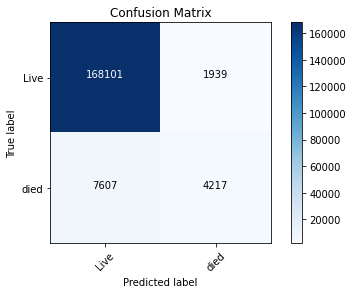

In [ ]:
import matplotlib.pyplot as pyplot
import itertools
cm_plot_labels = ['Live','died']
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

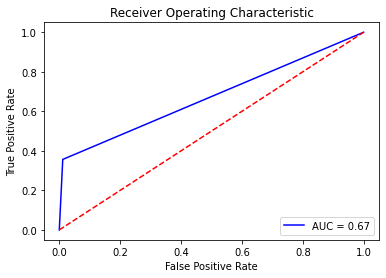

In [ ]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

buildROC(y_test,final_predictions)